In [10]:
import pandas as pd
import numpy as np

from matplotlib import figure
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

diabetesds = pd.read_csv('diabetes_prediction_dataset.csv')

In [4]:
X = diabetesds.drop('diabetes', axis=1)  
y = diabetesds['diabetes']

categorical_columns = ['gender', 'smoking_history']
onehot_encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_columns]))

X_encoded.columns = onehot_encoder.get_feature_names_out(categorical_columns)
X_encoded = pd.concat([X_encoded, X.select_dtypes(include=['float64'])], axis=1)

label_encoder = LabelEncoder()
categorical_columns = ['gender', 'smoking_history']
diabetesds[categorical_columns] = diabetesds[categorical_columns].apply(lambda x: label_encoder.fit_transform(x))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the decision tree classifier
classifier = DecisionTreeClassifier()

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the testing data
predictions = classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.945


In [8]:
rus = RandomUnderSampler(random_state=42)

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

classifier.fit(X_train_undersampled, y_train_undersampled)

y_pred = classifier.predict(X_train_undersampled)
print(classification_report(y_train_undersampled, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        83

    accuracy                           1.00       166
   macro avg       1.00      1.00      1.00       166
weighted avg       1.00      1.00      1.00       166



In [9]:
Q1 = np.percentile(X_train_undersampled, 25, axis=0)
Q3 = np.percentile(X_train_undersampled, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_mask = (X_train_undersampled < lower_bound) | (X_train_undersampled > upper_bound)

X_train_no_outliers = X_train_undersampled[~outliers_mask.any(axis=1)]
y_train_no_outliers = y_train_undersampled[~outliers_mask.any(axis=1)]

classifier.fit(X_train_no_outliers, y_train_no_outliers)

DecisionTreeClassifier()

In [ ]:
param_grid =  {    'criterion': ['gini', 'entropy'],
    'min_samples_split': [25, 30, 40, 50,54,53,52,55,56,57,60, 70, 80],
    'min_samples_leaf': [1, 2, 3, 4 , 5 ,],}   

model = DecisionTreeClassifier()

# Perform grid search using cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for predictions
predictions = best_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy on entire dataset: 88.80
[[803  94]
 [ 18  85]]


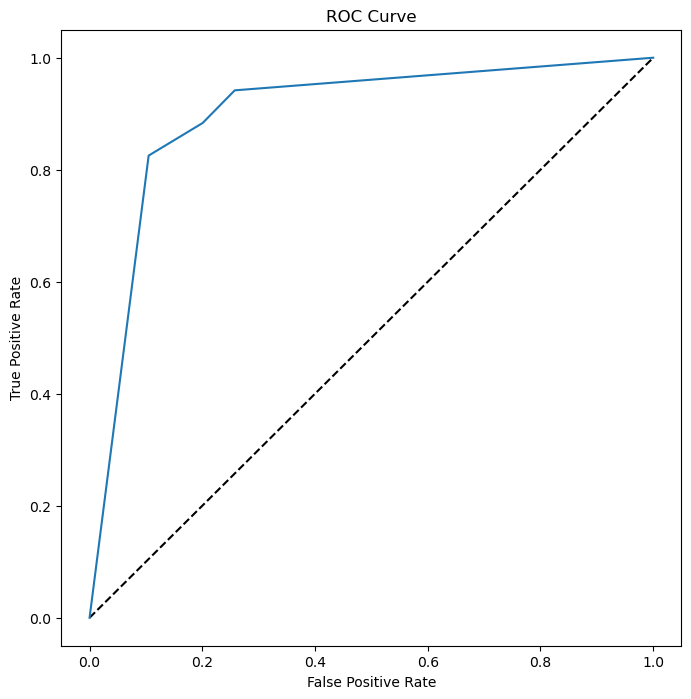

AUC:  0.9


In [17]:
from sklearn.metrics import confusion_matrix, roc_auc_score


entire_data_predictions = best_model.predict(X)

print(f'Accuracy on entire dataset: {accuracy_score(entire_data_predictions, y)*100:.2f}')

cm = confusion_matrix(y, entire_data_predictions)

print(cm)


y_pred_proba = best_model.predict_proba(X)[::,1]

fpr, tpr, _ = roc_curve(y,  y_pred_proba)


plt.figure(figsize=(8,8))

plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr, tpr)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.show()

auc = roc_auc_score(y, y_pred_proba)

print('AUC: ',round(auc, 2))